In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline

from keras.layers import concatenate, Dense, BatchNormalization, Activation, Lambda
from keras.models import Model
from keras.callbacks import LearningRateScheduler, History
from keras.optimizers import Adam

import tensorflow as tf

Using TensorFlow backend.


In [2]:
import sys
sys.path.append('/home/albert/github/DenseNet/')
import densenet
sys.path.append('/home/albert/github/tensorflow/src/')
import triplet
import evaluation
import data
import dense

### Data Preparation

In [3]:
train_dict, train_files = data.get_data('train')

preprocess False
keypoints ['Neck']
0.912821054459


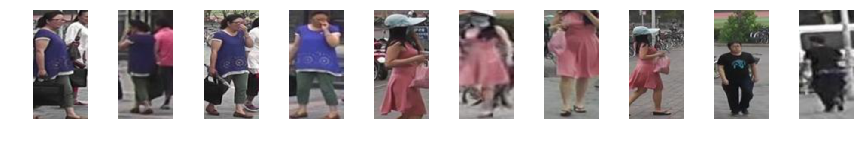

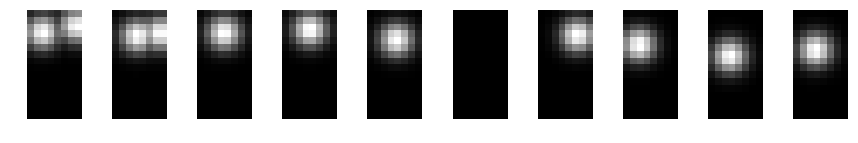

In [4]:
start = time.time()
batch = data.output_batch_generator(train_dict, P=5, K=4, preprocess=False,
                                    shape=(256,128), keypoints=['Neck'], r=0.5).next()
print time.time() - start

plt.figure(figsize=(15,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(batch[0]['input_im'][i].astype(np.uint8))
    plt.axis('off')
plt.show()

import cv2
plt.figure(figsize=(15,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(cv2.resize((255 * batch[0]['input_cam'][i]).astype(np.uint8), (8,16)), cmap=plt.cm.gray)
    plt.axis('off')
plt.show()

### Train Network

In [10]:
steps_per_epoch = 100

input_shape = (256,128)

preprocess = True

file_root = 'densenet_triplet_merge_cam_gap_2'

In [11]:
if os.path.exists('/home/albert/github/tensorflow/models/%s' % file_root) == False:
    os.system('mkdir /home/albert/github/tensorflow/models/%s' % file_root)

In [12]:
# First integer: number of epochs (e.g., 10)
# Second integer: era

epochs = 10

step_decay_cont_str = """
def step_decay_cont(epoch, init_epoch=%d*(%d - 1), init_lr=0.0001):
    drop = 0.5
    epochs_drop = 10.0
    lrate = init_lr * np.power(drop, (epoch + init_epoch)/(epochs_drop))
    return lrate
"""

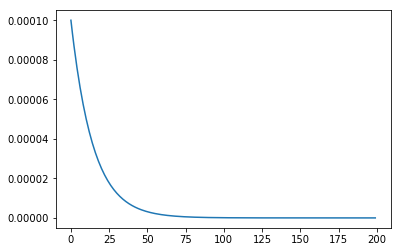

In [13]:
lr = []
for era in range(1,21):
    exec(step_decay_cont_str % (epochs, era))
    for j in range(10):
        lr.append(step_decay_cont(j))
plt.plot(np.arange(200), lr)

In [14]:
P_param = 18
K_param = 4

def_triplet_loss = """

import keras.backend as Keras

def triplet_loss(y_true, y_pred, margin='soft', P=%d, K=%d, output_dim=%d):
    embeddings = Keras.reshape(y_pred, (-1, output_dim))
    loss = Keras.variable(0, dtype='float32')

    for i in range(P):
        for a in range(K):
            pred_anchor = embeddings[i*K + a]
            hard_pos = Keras.max(triplet.dist(pred_anchor, embeddings[i*K:(i + 1)*K]))
            hard_neg = Keras.min(triplet.dist(pred_anchor, Keras.concatenate([embeddings[0:i*K],
                                                                    embeddings[(i + 1)*K:]], 0)))
            if margin == 'soft':
                loss += triplet.log1p(hard_pos - hard_neg)
            else:
                loss += Keras.maximum(margin + hard_pos - hard_neg, 0.0)
    return loss
""" % (P_param, K_param, 128)

exec(def_triplet_loss)

#### CAM-trained models

In [16]:
TF_ROOT = '/home/albert/github/tensorflow/models/branches/'
json_file = '/home/albert/github/tensorflow/models/branches/densenet_triplet/densenet_triplet.json'

base_model = evaluation.load_model(json_file, TF_ROOT + 'densenet_triplet/densenet_triplet_13000.npy')
neck_model = evaluation.load_model(json_file, TF_ROOT + 'densenet_triplet_cam_neck_r6_all/densenet_triplet_cam_neck_r6_all_4000.npy')
RHip_model = evaluation.load_model(json_file, TF_ROOT + 'densenet_triplet_cam_RHip_r6_all/densenet_triplet_cam_RHip_r6_all_5000.npy')
LHip_model = evaluation.load_model(json_file, TF_ROOT + 'densenet_triplet_cam_LHip_r6_all/densenet_triplet_cam_LHip_r6_all_5000.npy')
RShoulder_model = evaluation.load_model(json_file, TF_ROOT + 'densenet_triplet_cam_RShoulder_r6_all/densenet_triplet_cam_RShoulder_r6_all_5000.npy')
LShoulder_model = evaluation.load_model(json_file, TF_ROOT + 'densenet_triplet_cam_LShoulder_r6_all/densenet_triplet_cam_LShoulder_r6_all_5000.npy')

In [17]:
for layer in base_model.layers:
    layer.name = layer.name + '_b'
for layer in neck_model.layers:
    layer.name = layer.name + '_n'
for layer in RHip_model.layers:
    layer.name = layer.name + '_RH'
for layer in LHip_model.layers:
    layer.name = layer.name + '_LH'
for layer in RShoulder_model.layers:
    layer.name = layer.name + '_RS'
for layer in LShoulder_model.layers:
    layer.name = layer.name + '_LS'

In [18]:
for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in neck_model.layers[:-4]:
    layer.trainable = False
for layer in RHip_model.layers[:-4]:
    layer.trainable = False
for layer in LHip_model.layers[:-4]:
    layer.trainable = False
for layer in RShoulder_model.layers[:-4]:
    layer.trainable = False
for layer in LShoulder_model.layers[:-4]:
    layer.trainable = False

In [19]:
# base_model_output_l2 = Lambda(lambda i : tf.nn.l2_normalize(i, 0))(base_model.output)
# neck_model_output_l2 = Lambda(lambda i : tf.nn.l2_normalize(i, 0))(neck_model.output)

In [20]:
base_model.layers[-5]

In [21]:
x = concatenate([base_model.layers[-5].output, neck_model.layers[-5].output, 
                 RHip_model.layers[-5].output, LHip_model.layers[-5].output, 
                 RShoulder_model.layers[-5].output, LShoulder_model.layers[-5].output])
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
predictions = Dense(128, name='final_output')(x)

In [22]:
model = Model(inputs=[base_model.input, neck_model.input, 
                      RHip_model.input, LHip_model.input, 
                      RShoulder_model.input, LShoulder_model.input], outputs=predictions)
model.compile(loss=triplet_loss, 
              optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))

In [23]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_im_b (InputLayer)          (None, 256, 128, 3)   0                                            
____________________________________________________________________________________________________
input_im_n (InputLayer)          (None, 256, 128, 3)   0                                            
____________________________________________________________________________________________________
input_im_RH (InputLayer)         (None, 256, 128, 3)   0                                            
____________________________________________________________________________________________________
input_im_LH (InputLayer)         (None, 256, 128, 3)   0                                            
___________________________________________________________________________________________

conv2d_31_RH (Conv2D)            (None, 32, 16, 128)   49152       activation_31_RH[0][0]           
____________________________________________________________________________________________________
conv2d_31_LH (Conv2D)            (None, 32, 16, 128)   49152       activation_31_LH[0][0]           
____________________________________________________________________________________________________
conv2d_31_RS (Conv2D)            (None, 32, 16, 128)   49152       activation_31_RS[0][0]           
____________________________________________________________________________________________________
conv2d_31_LS (Conv2D)            (None, 32, 16, 128)   49152       activation_31_LS[0][0]           
____________________________________________________________________________________________________
batch_normalization_32_b (BatchN (None, 32, 16, 128)   512         conv2d_31_b[0][0]                
___________________________________________________________________________________________

____________________________________________________________________________________________________
conv2d_108_RH (Conv2D)           (None, 8, 4, 32)      36864       activation_108_RH[0][0]          
____________________________________________________________________________________________________
conv2d_108_LH (Conv2D)           (None, 8, 4, 32)      36864       activation_108_LH[0][0]          
____________________________________________________________________________________________________
conv2d_108_RS (Conv2D)           (None, 8, 4, 32)      36864       activation_108_RS[0][0]          
____________________________________________________________________________________________________
conv2d_108_LS (Conv2D)           (None, 8, 4, 32)      36864       activation_108_LS[0][0]          
____________________________________________________________________________________________________
concatenate_52_b (Concatenate)   (None, 8, 4, 832)     0           concatenate_51_b[0][0]  

In [24]:
model_json = model.to_json()
with open("/home/albert/github/tensorflow/models/%s/%s.json" % (file_root, file_root), "w") as json_file:
    json_file.write(model_json)

In [25]:
train_score = {}
history = History()

for era in range(1,5):
    iterations = era * steps_per_epoch * epochs
    exec(step_decay_cont_str % (epochs, era))
    lrate = LearningRateScheduler(step_decay_cont)
    
    model.fit_generator(data.output_batch_generator(train_dict, model=model, P=P_param, K=K_param, 
                                                    preprocess=True,
                                                    shape=(256,128)), 
                         steps_per_epoch=steps_per_epoch,
                         epochs=epochs,
                         callbacks=[lrate, history])
    
#     file_name = file_root + '_' + str(iterations) + '.npy'
#     np.save('/home/albert/github/tensorflow/models/%s/%s' % (file_root, file_name), model.get_weights())
    
    train_score[iterations] = evaluation.get_score(model,
                                                   hist=history, preprocess=preprocess, 
                                                   shape=input_shape)
    print 'train' , iterations, train_score[iterations]

preprocess True
keypoints None
Epoch 1/10
100/100 [==============================] - 516s - loss: 36.1831   
Epoch 2/10
100/100 [==============================] - 512s - loss: 23.4716   
Epoch 3/10
100/100 [==============================] - 513s - loss: 19.9632   
Epoch 4/10
100/100 [==============================] - 512s - loss: 12.4681   
Epoch 5/10
100/100 [==============================] - 515s - loss: 13.1350   
Epoch 6/10
100/100 [==============================] - 511s - loss: 12.6386   
Epoch 7/10
100/100 [==============================] - 507s - loss: 9.6909   
Epoch 8/10
100/100 [==============================] - 506s - loss: 7.6663   
Epoch 9/10
100/100 [==============================] - 503s - loss: 10.0804   
Epoch 10/10
100/100 [==============================] - 501s - loss: 9.5757   
preprocess True
1000 120.879720926
2000 238.62343502
3000 356.713428974
4000 474.474457979
5000 592.317891121
6000 710.055850983
7000 827.916897058
8000 945.737514973
9000 1063.59798002
10000

In [26]:
np.savez('/home/albert/github/tensorflow/models/%s/%s_score.npz' % (file_root, file_root), train_score)

### Evaluation